In [2]:
import numpy as np

In [3]:
!git clone https://github.com/HansBambel/multidim_conv.git

Cloning into 'multidim_conv'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 59 (delta 10), reused 12 (delta 3), pack-reused 34
Unpacking objects: 100% (59/59), 145.58 MiB | 12.52 MiB/s, done.


In [37]:
import pickle
with open('./multidim_conv/data/Wind_data_NL/dataset.pkl', 'rb') as f:
    data = pickle.load(f)

with open('./multidim_conv/data/Wind_data_NL/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
train_data = data['train']
test_data = data['test']
print(train_data.shape, test_data.shape)

# history_length is timestep of the historical window size
# predict_length is the prediction horizon
def build_data(data, x_len, y_len):
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len, length):
        xtime = data[end_idx-y_len-x_len:end_idx-y_len]
        ytime = data[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y


"""Build data and train test split"""
x_len = 10  # previous 10 time steps
y_len = 1  # next step
x, y = build_data(train_data[:, :, 0], x_len, y_len)
xtest, ytest = build_data(test_data[:, :, 0], x_len, y_len)
y, x = y.reshape(70117, 7), x.reshape(70117, 10, 7)
ytest, xtest = ytest.reshape(10861, 7),xtest.reshape(10861, 10, 7)

print(x.shape)
print(y.shape)

xtrain = x[:60000]
ytrain = y[:60000]
xval = x[60000:]
yval = y[60000:]

(70128, 7, 6) (10872, 7, 6)
(70117, 10, 7)
(70117, 7)


In [38]:
"""convert arrays to tensors"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'

xtrain = torch.Tensor(xtrain).to(device)
ytrain = torch.Tensor(ytrain).to(device)
xval = torch.Tensor(xval).to(device)
yval = torch.Tensor(yval).to(device)
xtest = torch.Tensor(xtest).to(device)
ytest = torch.Tensor(ytest).to(device)

batch_size = 32
train_data = torch.utils.data.TensorDataset(xtrain, ytrain)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
val_data = torch.utils.data.TensorDataset(xval, yval)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(xtest, ytest)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [140]:
import torch
from torch import nn
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = x_len
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))

        lstm_out, _ = self.lstm(x, (h0, c0))
        #hn = hn.view(-1, self.hidden_size)
        out = lstm_out[:, -1, :]
        out = self.linear(out)
    
        return out

In [141]:
input_size = output_size = 7
hidden_size = 16
num_layers = 1

lstm = LSTM(output_size, input_size, hidden_size, num_layers)
lstm = lstm.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)

"""Validation loop"""
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in val_iter:
            outputs = model(x)
            loss = loss_fn(outputs.cpu(), y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss


"""Train loop"""
NUM_EPOCHS = 50
for epoch in range(NUM_EPOCHS):
    losses = []
    
    for x, y in train_iter:
        outputs = lstm(x)
        loss = loss_fn(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    train_loss = np.mean(losses)
    val_loss = validate(lstm) 
    
    if epoch % 5 == 0:
        print('Epoch: ', epoch+1, ', Train Loss: ', train_loss, ', Val Loss: ', val_loss)

Epoch:  1 , Train Loss:  0.002255651927056412 , Val Loss:  0.0020080523
Epoch:  6 , Train Loss:  0.0016525561397895217 , Val Loss:  0.0017737006
Epoch:  11 , Train Loss:  0.0016183330227931341 , Val Loss:  0.0016911528
Epoch:  16 , Train Loss:  0.0016011167417901257 , Val Loss:  0.0016625588
Epoch:  21 , Train Loss:  0.0015915929171877602 , Val Loss:  0.0016487574
Epoch:  26 , Train Loss:  0.0015853790460154415 , Val Loss:  0.0016409116
Epoch:  31 , Train Loss:  0.0015805157193293175 , Val Loss:  0.0016386473
Epoch:  36 , Train Loss:  0.001576481980116417 , Val Loss:  0.0016371815
Epoch:  41 , Train Loss:  0.0015734707022085786 , Val Loss:  0.0016383076
Epoch:  46 , Train Loss:  0.0015789715522900223 , Val Loss:  0.0016310115


In [142]:
"""Test data predictions"""
lstm.eval()
y_preds = list()
y_true = list()

max_wind = scaler['feature_max_train'][0]
min_wind = scaler['feature_min_train'][0]

with torch.no_grad():
    for x, y in test_iter:
        y = y.cpu().numpy().reshape(-1)
        y_pred = lstm(x).view(len(y), -1).cpu().numpy().reshape(-1)
        y = y * max_wind + min_wind
        y_pred = y_pred * max_wind + min_wind
        y_preds.extend(list(y_pred))
        y_true.extend(list(y))
        
y_preds = np.array(y_preds)
y_true = np.array(y_true)
y_true = y_true.reshape(int(y_true.shape[0]/7), 7)
y_preds = y_preds.reshape(int(y_preds.shape[0]/7), 7)

"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))

RMSE:  9.952879
MAE:  7.4947724


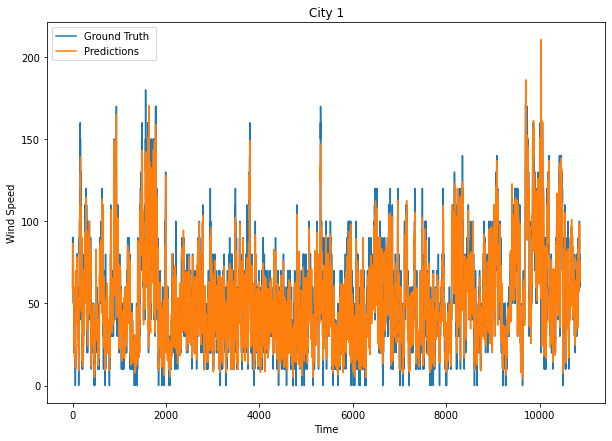

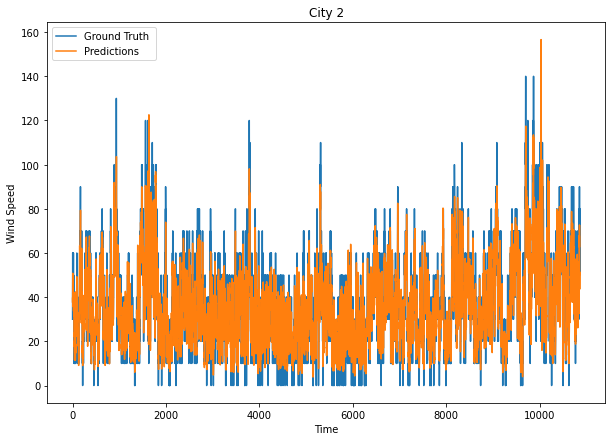

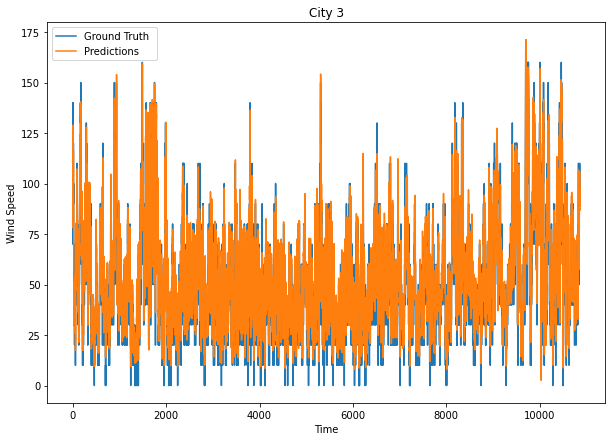

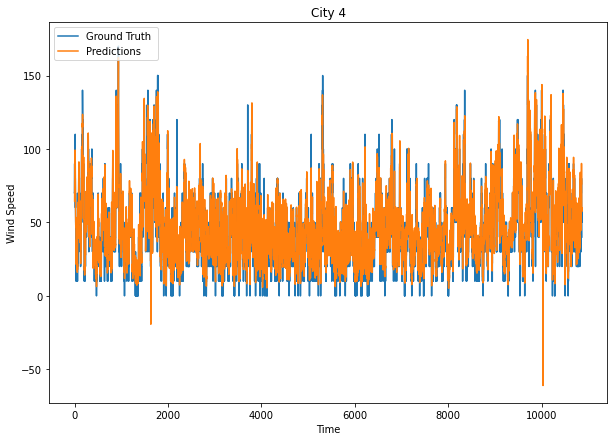

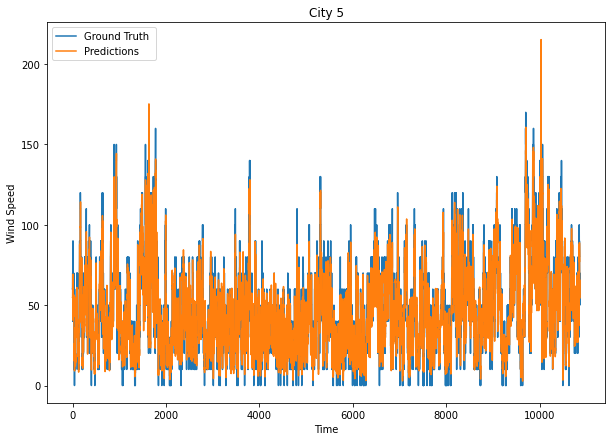

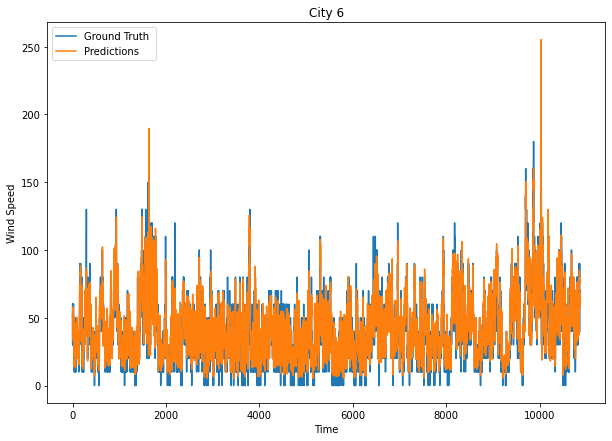

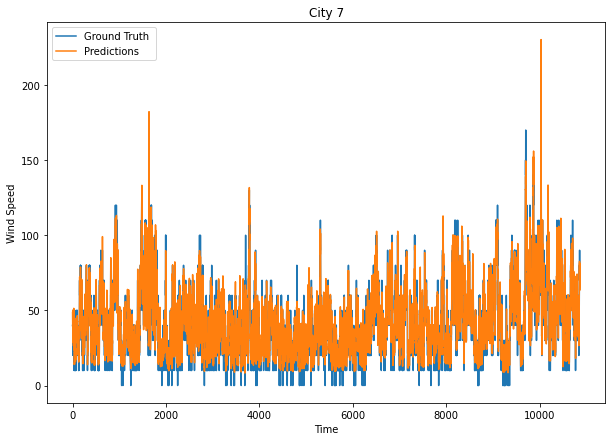

In [143]:
"""Visualization of windspeed predictions vs ground truth"""
import matplotlib.pyplot as plt

for i in range(7):
    plt.figure(figsize=(10,7))
    plt.plot(range(len(y_true[:, i])), y_true[:, i], label='Ground Truth ')
    plt.plot(range(len(y_preds[:, i])), y_preds[:, i], label='Predictions')
    plt.title('City '+str(i+1))
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    plt.legend(loc="upper left")
    plt.show()

## References:
- Dataset from "Trebing, Kevin and Mehrkanoon, Siamak, 2020, Wind speed prediction using multidimensional convolutional neural networks"